# On Analyzing Real World Time Series for Forecasting: Bitcoin Price Dataset (2017-2023)

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

# from collections import namedtuple
from data_loader import build_bitcoin_uts

from ts_models import RandomWalk, ARMA, EvaluationMetric
# from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Initialize & Predict Random Walk Model on Raw Data
    1. Split Raw Data
7. Difference
8. Get Descriptive Statistics (ie: mean, median, etc)
9. Check Stationarity of Differenced Data
10. Plot Autocorrelation and Partial Autocorrelation of Differenced Data
11. Initialize & Predict Random Walk `RW` Model on Raw Data
    1. Split Differenced Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Follow-up

### Load Raw Data

In [2]:
reversed_bitcoin_ts = build_bitcoin_uts()

In [3]:
reversed_bitcoin_df = reversed_bitcoin_ts.get_as_df()
reversed_bitcoin_df

,close
Timestamp,
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28908.53
2023-08-01,28907.41
...,...
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56


In [4]:
bitcoin_ts = reversed_bitcoin_ts.data_augment_reverse()
bitcoin_ts

UnivariateTimeSeries(close)

In [5]:
bitcoin_df = bitcoin_ts.get_as_df()
bitcoin_df

,close
Timestamp,
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


### Plot Raw Data

- August 2017 to July 2023. The data has been meticulously collected from the Binance API, with price data captured at **one-minute intervals** [About Dataset](https://www.kaggle.com/datasets/jkraak/bitcoin-price-dataset)

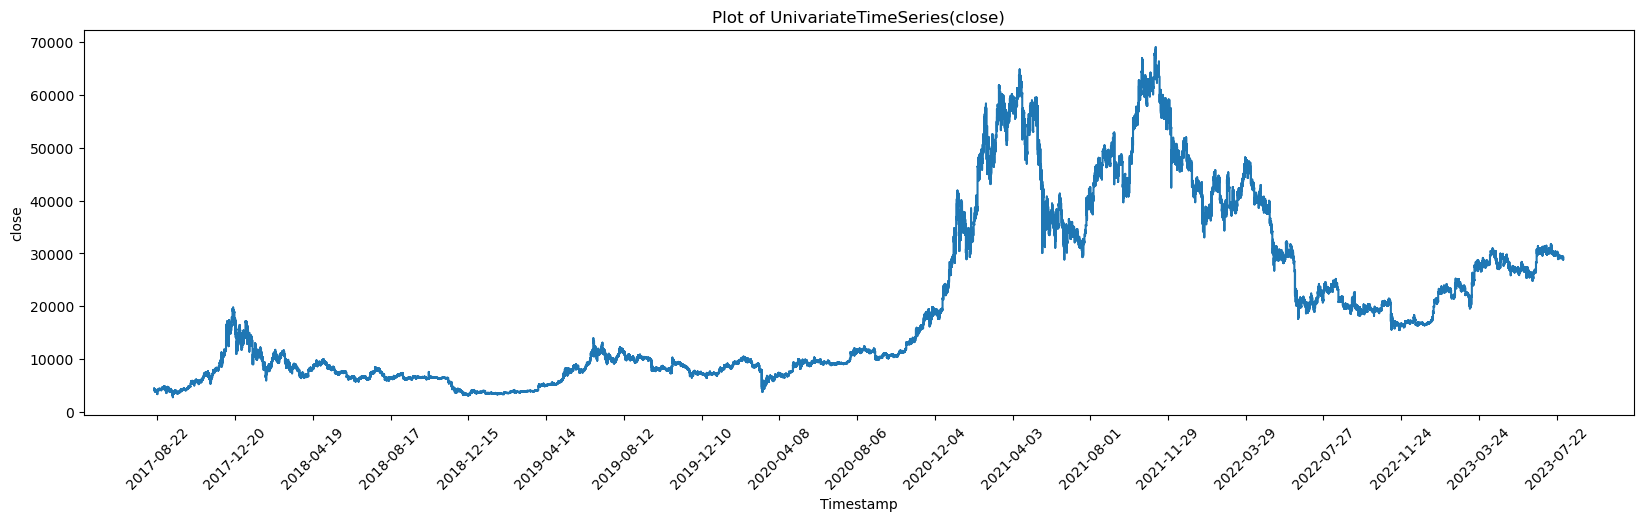

In [6]:
bitcoin_ts.plot(tick_skip=120)

### Get Descriptive Statistics of Raw Data

In [7]:
bitcoin_ts.get_statistics()

,close
count,3.126000e+06
mean,2.008946e+04
std,1.605896e+04
min,2.817000e+03
25%,7.624798e+03
50%,1.170000e+04
75%,2.989957e+04
max,6.900000e+04


In [8]:
bitcoin_ts.range_skewness_kurtosis()

{'Range': close    66183.0
 dtype: float64,
 'Skewness': close    1.029161
 dtype: float64,
 'Kurtosis': close   -0.056707
 dtype: float64}

### Check Stationarity of Raw Data

In [9]:
# both a taking a while
# bitcoin_ts.stationarity_test(bitcoin_df)

# from statsmodels.tsa.stattools import adfuller, bds

# adfuller(bitcoin_df)

- Stationarity test is taking a while. From looking at the graph, we can see that the time series is NOT stationary, so we can difference.

In [10]:
# bitcoin_series = bitcoin_ts.get_series()
# bitcoin_ts.independence_test(bitcoin_series)

- Independence test is taking a while as well. Assume that the data is dependent as there is correlation due to the time series being non-stationary.

### Difference

In [11]:
differenced_bitcoin_ts = bitcoin_ts.data_augment_with_differencing(1)
differenced_bitcoin_ts

UnivariateTimeSeries(Order-1 Difference of close)

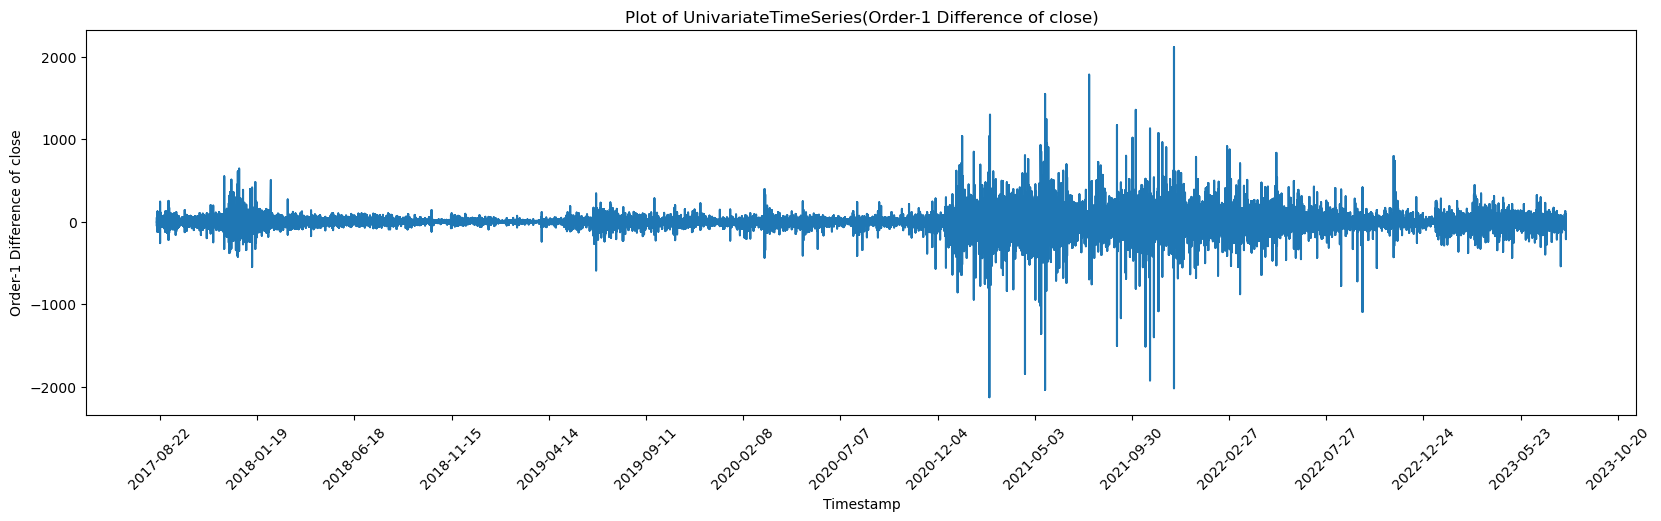

In [12]:
differenced_bitcoin_ts.plot(tick_skip=150)

- Data is differenced once. Will difference again to see plot and choose which is best as stationarity and independence test are taking a while on the raw data and assuming it'll take the same time on the differences as it's the same length. 

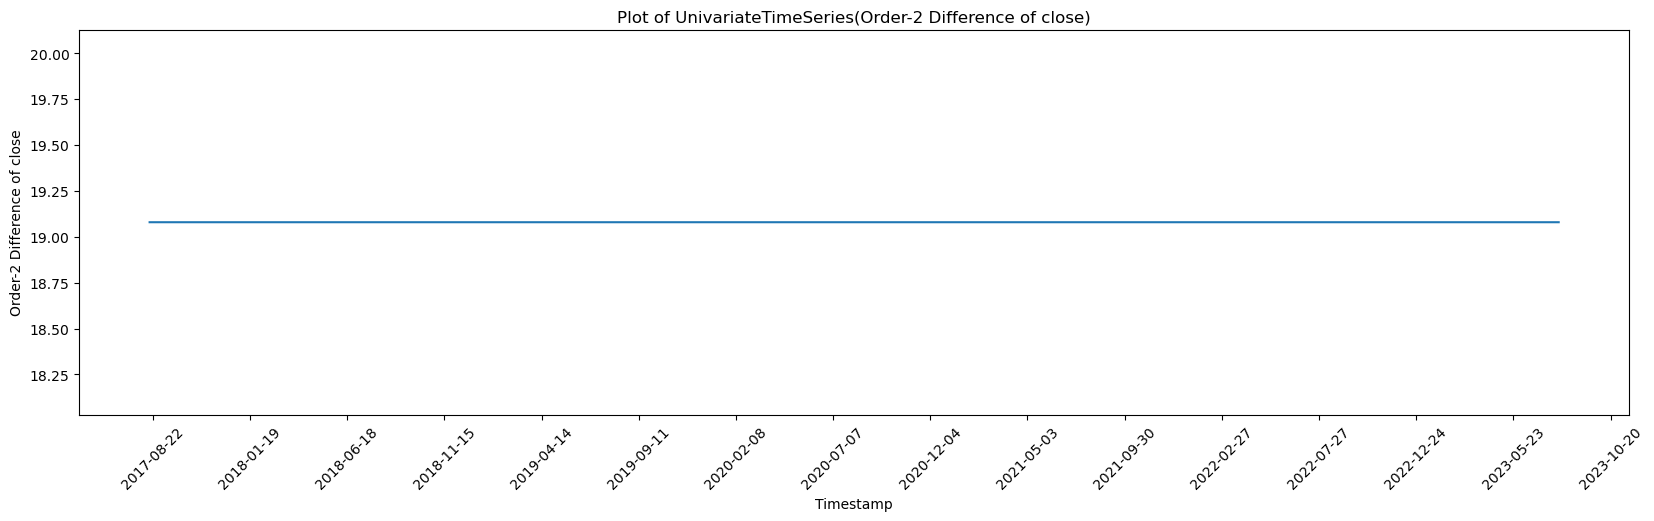

In [13]:
differenced_2_bitcoin_ts = bitcoin_ts.data_augment_with_differencing(2)
differenced_2_bitcoin_ts.plot(tick_skip=150)

- Too much differencing or code for 2nd diff and after is wrong? Will go with difference 1. 

### Get Descriptive Statistics of Differenced Data

In [14]:
differenced_bitcoin_ts.get_statistics()

,Order-1 Difference of close
count,3.125999e+06
mean,7.882603e-03
std,2.862586e+01
min,-2.129570e+03
25%,-5.180000e+00
50%,0.000000e+00
75%,5.160000e+00
max,2.115780e+03


In [15]:
differenced_bitcoin_ts.range_skewness_kurtosis()

{'Range': Order-1 Difference of close    4245.35
 dtype: float64,
 'Skewness': Order-1 Difference of close   -0.35713
 dtype: float64,
 'Kurtosis': Order-1 Difference of close    154.179352
 dtype: float64}

### Check Stationarity of Difference Data

In [16]:
# differenced_bitcoin_df = differenced_bitcoin_ts.get_as_df()
# differenced_bitcoin_ts.stationarity_test(differenced_bitcoin_df)

- Taking a while on the raw data and assuming it'll take the same time on the differenced data

### Plot Autocorrelation and Partial Autocorrelation of Difference Data

In [17]:
# differenced_bitcoin_ts.plot_autocorrelation(30)

- Exponentially dies out at lag 1, so no correlation between $ z_0 $  and $ z_1 $. With this, there doesn't exists any correlation between $ z_0 $ and the remaining $ z_{t - 1} $.
- Takes a while on entire dataset. Can run, have it print for first 30 or k lags, stop cell from running, and continue.

In [18]:
# differenced_bitcoin_ts.plot_partial_autocorrelation(35)

### Initialize & Predict (RW) Model of Raw Data
- RW uses the raw data because the current observation depends on the previous, thus dependency is need and dependency is in raw data. Differencing removes this dependence.

#### Split Differenced Data
- Forecast for the entirety of the next day. Observations are currently in minutes, so would need 1440 as forecasting step (60 mins = 1 hr and 24 hrs in a day, so 60 * 24). 

In [19]:
bitcoin_series = bitcoin_ts.get_series()
bitcoin_series

array([ 4261.48,  4261.48,  4280.56, ..., 28902.49, 28902.49, 28902.49])

In [20]:
forecasting_step = 1440
N = len(bitcoin_ts.get_series())
train_length = N - forecasting_step
train_length

3124560

In [21]:
train_uts, test_uts = bitcoin_ts.get_slice(1, train_length, both_train_test=True)
train_uts, test_uts

1 3124560


(UnivariateTimeSeries(UnivariateTimeSeries(close)[1:3124560]),
 UnivariateTimeSeries(UnivariateTimeSeries(close)[3124560:3126000]))

In [22]:
train_df = train_uts.get_as_df()
train_df

,UnivariateTimeSeries(close)[1:3124560]
Timestamp,
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2023-07-31,29445.99
2023-07-31,29446.01
2023-07-31,29449.99


In [23]:
test_df = test_uts.get_as_df()
test_df

,UnivariateTimeSeries(close)[3124560:3126000]
Timestamp,
2023-07-31,29453.99
2023-07-31,29438.00
2023-07-31,29439.99
2023-07-31,29440.00
2023-07-31,29439.99
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


In [24]:
rw_model_class = RandomWalk()

rw_predictions = rw_model_class.predict(train_df, test_df)

In [25]:
type(rw_predictions[0]), len(rw_predictions), rw_predictions

(numpy.ndarray,
 1440,
 [array([29453.99]),
  array([29453.99]),
  array([29438.]),
  array([29439.99]),
  array([29440.]),
  array([29439.99]),
  array([29440.95]),
  array([29436.45]),
  array([29433.51]),
  array([29432.91]),
  array([29431.99]),
  array([29445.57]),
  array([29436.78]),
  array([29451.99]),
  array([29425.88]),
  array([29421.53]),
  array([29421.99]),
  array([29404.4]),
  array([29406.44]),
  array([29402.18]),
  array([29402.52]),
  array([29398.83]),
  array([29398.4]),
  array([29396.18]),
  array([29395.]),
  array([29401.39]),
  array([29421.52]),
  array([29427.99]),
  array([29418.]),
  array([29413.33]),
  array([29410.01]),
  array([29413.99]),
  array([29408.]),
  array([29394.01]),
  array([29361.99]),
  array([29348.]),
  array([29330.01]),
  array([29335.13]),
  array([29344.01]),
  array([29347.8]),
  array([29363.99]),
  array([29334.48]),
  array([29320.]),
  array([29325.03]),
  array([29330.97]),
  array([29339.71]),
  array([29336.94]),
  array

In [26]:
rw_mse_gsts = EvaluationMetric.eval_mse(test_df, rw_predictions, per_element=False)
rw_rmse_gsts = EvaluationMetric.eval_rmse(test_df, rw_predictions, per_element=False)

Test MSE: 125.932
Test RMSE: 11.222


- Both `MSE` and `RMSE` for the raw TS are high. Why?

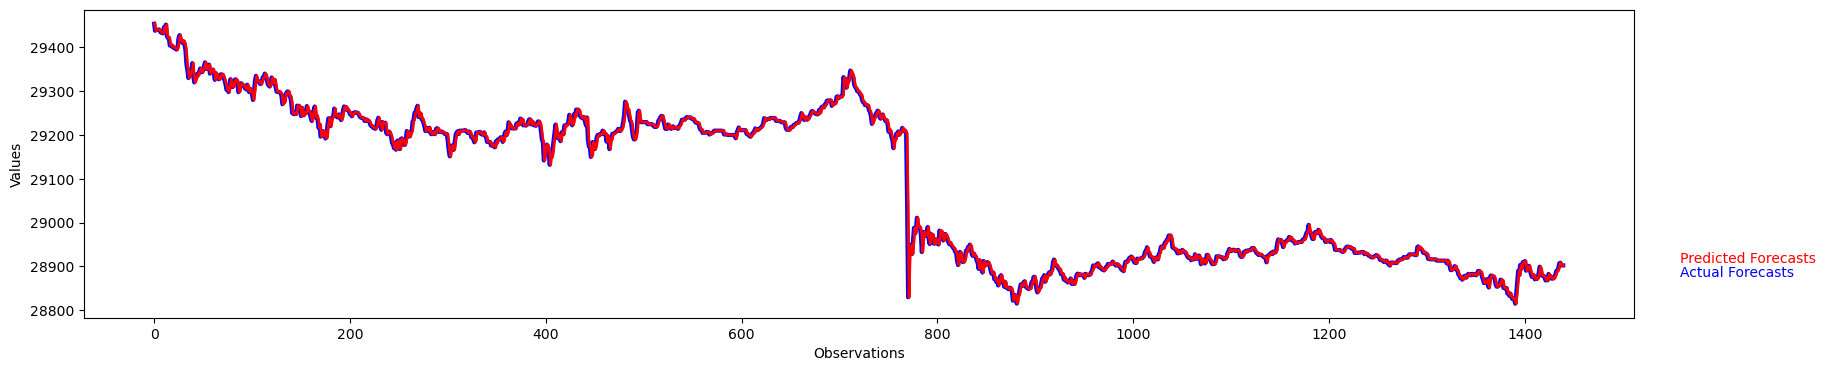

In [27]:
# EvaluationMetric.plot_forecast(train_df, test_df, rw_predictions, per_element=False)
# EvaluationMetric.plot_forecast_only(test_df, rw_predictions, per_element=True)
EvaluationMetric.plot_predictions(test_df, rw_predictions, lag=1)

### Initialize Autoregressive ARMA(p, q) Model
- How to determine the proper lag p value? Look at the Partial ACor plot. Assumption: Being that we're out of the blue area at lag 1, we'll set our lag to be 1. Assuming because it takes a while to run PACor plot on entire dataset. 

- How to determine the proper error q value? Look at the ACor plot. Assumption: Being that we're out of the blue area at lag 1, we'll set our error to be 1. Assuming because it takes a while to run ACor plot on entire dataset. 

### Predict + Plot Actual Forecasts vs Predicted Forecasts for Differences Data

#### Split Differenced Data

In [28]:
diff_bitcoin_series = differenced_bitcoin_ts.get_series()
len(diff_bitcoin_series), diff_bitcoin_series

(3125999, array([  0.  ,  19.08, -19.08, ...,  -6.04,   0.  ,   0.  ]))

In [29]:
# forecasting_step = 1440
diff_N = len(diff_bitcoin_series)
diff_train_length = diff_N - forecasting_step
diff_train_length

3124559

In [30]:
diff_train_uts, diff_test_uts = differenced_bitcoin_ts.get_slice(1, diff_train_length, both_train_test=True)
diff_train_uts, diff_test_uts

1 3124559


(UnivariateTimeSeries(UnivariateTimeSeries(Order-1 Difference of close)[1:3124559]),
 UnivariateTimeSeries(UnivariateTimeSeries(Order-1 Difference of close)[3124559:3125999]))

In [31]:
diff_train_df = diff_train_uts.get_as_df()
diff_train_df

,UnivariateTimeSeries(Order-1 Difference of close)[1:3124559]
Timestamp,
2017-08-17,19.08
2017-08-17,-19.08
2017-08-17,0.00
2017-08-17,0.00
2017-08-17,0.00
...,...
2023-07-31,6.92
2023-07-31,0.02
2023-07-31,3.98


In [32]:
diff_test_df = diff_test_uts.get_as_df()
diff_test_df

,UnivariateTimeSeries(Order-1 Difference of close)[3124559:3125999]
Timestamp,
2023-07-31,0.00
2023-07-31,-15.99
2023-07-31,1.99
2023-07-31,0.01
2023-07-31,-0.01
...,...
2023-08-01,11.42
2023-08-01,1.12
2023-08-01,-6.04


In [33]:
arma_model_class = ARMA()

lag_p, error_q = 1, 1
arma_model = arma_model_class.train_arma_model(diff_train_df, lag_p, error_q)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
# retrain false
arma_predictions_no_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, False, lag_p)

# retrain true
arma_predictions_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, True, lag_p)

Predictions for dates [datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31), datetime.date(2023, 7, 31

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


predicted=-2.158729, expected=-6.560000
predicted=-3.954120, expected=0.000000
predicted=-0.510329, expected=-0.010000
predicted=-0.515579, expected=0.000000
predicted=-0.510329, expected=0.000000
predicted=-0.510329, expected=10.990000
predicted=5.259070, expected=-3.980000
predicted=-2.599702, expected=6.760000
predicted=3.038455, expected=-4.070000
predicted=-2.646949, expected=12.840000
predicted=6.230261, expected=-3.320000
predicted=-2.253223, expected=0.830000
predicted=-0.074606, expected=-13.040000
predicted=-7.355913, expected=0.430000
predicted=-0.284593, expected=-0.010000
predicted=-0.515579, expected=-1.040000
predicted=-1.056296, expected=2.610000
predicted=0.859837, expected=6.690000
predicted=3.001707, expected=4.970000
predicted=2.098762, expected=0.010000
predicted=-0.505080, expected=-11.670000
predicted=-6.636707, expected=6.720000
predicted=3.017456, expected=-2.710000
predicted=-1.932993, expected=-6.010000
predicted=-3.665387, expected=0.010000
predicted=-0.5050

In [35]:
len(diff_test_df), len(arma_predictions_no_retrain), len(arma_predictions_retrain)

(1440, 1440, 1440)

In [36]:
arma_mse_no_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_no_retrain, per_element=False)
arma_rmse_no_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_no_retrain, per_element=False)

arma_mse_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_retrain, per_element=False)
arma_rmse_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_retrain, per_element=False)

Test MSE: 125.932
Test RMSE: 11.222
Test MSE: 145.980
Test RMSE: 12.082


In [37]:
# import numpy as np
arma_predictions_no_retrain = list(arma_predictions_no_retrain)
arma_predictions_no_retrain

[-0.002729073151444262,
 0.001392725851072671,
 -0.0007107487372478779,
 0.00036271586910688715,
 -0.00018510451697936845,
 9.446424908436606e-05,
 -4.8207869265922645e-05,
 2.4601885704767792e-05,
 -1.2555061848757152e-05,
 6.407215280882679e-06,
 -3.2697893606665395e-06,
 1.6686691478946527e-06,
 -8.515706726037731e-07,
 4.3458142158005815e-07,
 -2.2177961038169674e-07,
 1.1318062194703411e-07,
 -5.775938176765164e-08,
 2.947630190389453e-08,
 -1.5042619005595733e-08,
 7.676688455874884e-09,
 -3.917638652327806e-09,
 1.9992855901905535e-09,
 -1.0202939132144165e-09,
 5.206858262021329e-10,
 -2.6572120650378e-10,
 1.356053036834811e-10,
 -6.920335275095006e-11,
 3.5316495018150365e-11,
 -1.8023040369961214e-11,
 9.19768465161422e-12,
 -4.693847498202205e-12,
 2.395407667353804e-12,
 -1.2224465952537016e-12,
 6.238502525535446e-13,
 -3.183690306981064e-13,
 1.624730282512024e-13,
 -8.291473844435403e-14,
 4.231381617794622e-14,
 -2.1593978020477516e-14,
 1.1020038580020574e-14,
 -5.623

In [38]:
# import numpy as np
# arma_predictions_no_retrain = [np.array(value) for value in arma_predictions_no_retrain]
# arma_predictions_no_retrain

In [39]:
arma_predictions_retrain

[array([-0.51557893]),
 array([-0.51032925]),
 array([-8.90456869]),
 array([0.53435721]),
 array([-0.50507957]),
 array([-0.51557893]),
 array([-0.0063599]),
 array([-2.87268557]),
 array([-2.05373538]),
 array([-0.82531009]),
 array([-0.99329987]),
 array([6.61873715]),
 array([-5.12479859]),
 array([7.4744351]),
 array([-14.21724556]),
 array([-2.79394035]),
 array([-0.26884394]),
 array([-9.74451761]),
 array([0.56060561]),
 array([-2.74669323]),
 array([-0.3318401]),
 array([-2.44746143]),
 array([-0.73606552]),
 array([-1.67575836]),
 array([-1.12979157]),
 array([2.84421672]),
 array([10.05727801]),
 array([2.88621417]),
 array([-5.75476027]),
 array([-2.96193014]),
 array([-2.25322324]),
 array([1.57904367]),
 array([-3.65488799]),
 array([-7.85463255]),
 array([-17.31980686]),
 array([-7.85463255]),
 array([-9.95450483]),
 array([2.17750727]),
 array([4.15138722]),
 array([1.47929974]),
 array([7.98890381]),
 array([-16.002137]),
 array([-8.11186691]),
 array([2.13026014]),
 a

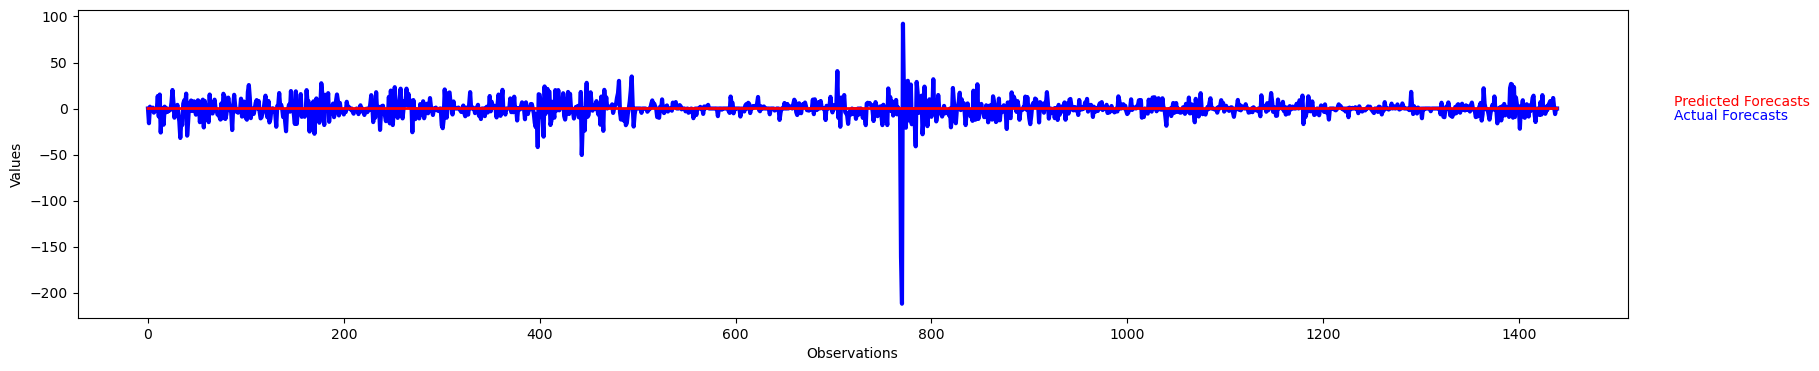

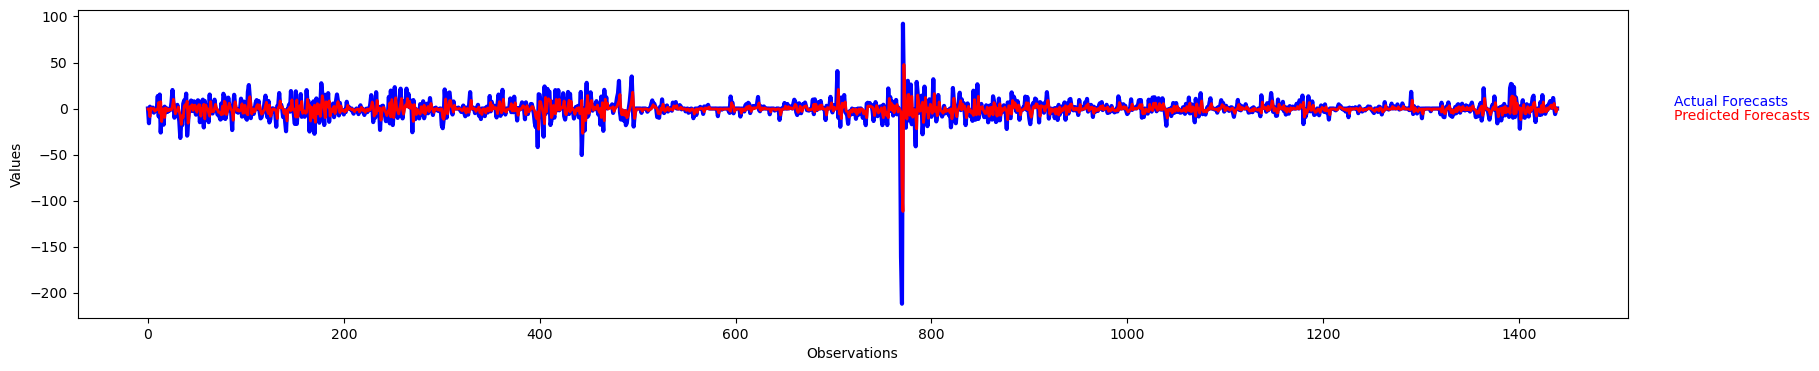

In [40]:
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_no_retrain, lag=lag_p)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_retrain, lag=lag_p)

### Follow-up
- What can we determine from this?
    - `RW` on raw TS vs 
    - `AR-no-retrain` on differenced TS vs
    - `AR-retrain` on differenced TS